In [3]:
from apps.onedimensional.linearsystem import linear_system
from apps.onedimensional.linearsystem.smoothexample import smooth_example
from pydogpack import main
from pydogpack.tests.utils import utils
from pydogpack.utils import dg_utils
from pydogpack.utils import math_utils
from pydogpack.utils import x_functions
from pydogpack.visualize import plot

import numpy as np

from IPython.display import HTML

# Constant Linear System Smooth Example

0.0014924283662731655


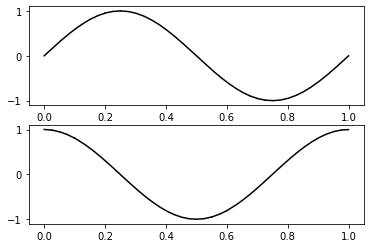

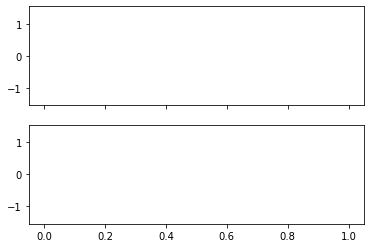

In [35]:
matrix = np.array([[2, 1], [1, 2]])
initial_condition = x_functions.ComposedVector([x_functions.Sine(), x_functions.Cosine()])
time_final = 1.0
problem = smooth_example.SmoothExample(matrix, initial_condition)
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

space_time_order = 2
problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["order"] = space_time_order

num_elems = 40
x_left = 0.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right
problem.parameters["mesh"]["num_elems"] = num_elems

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5
problem.parameters["basis"]["num_basis_cpts"] = space_time_order

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

cfl = dg_utils.standard_cfls(space_time_order)
problem.parameters["delta_t"] = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems))

final_solution = main.run(problem)
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
error = math_utils.compute_error(final_solution, exact_final_solution)
print(error)

p = plot.create_plot_dg_1d(final_solution)
ani, fig = plot.create_animation_output_dir(problem.output_dir)
HTML(ani.to_html5_video())

# Convergence Test

## DG Convergence

In [24]:
matrix = np.array([[2, 1], [1, 2]])
initial_condition = x_functions.ComposedVector([x_functions.Sine(), x_functions.Cosine()])
time_final = 1.0

problem = smooth_example.SmoothExample(matrix, initial_condition)
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False

x_left = 0.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "exact_linear"

In [27]:
for num_basis_cpts in range(1, 5):
    problem.parameters["basis"]["num_basis_cpts"] = num_basis_cpts
    problem.parameters["time_stepping"]["order"] = num_basis_cpts
    
    cfl = dg_utils.standard_cfls(num_basis_cpts)
    error_list = []
    for num_elems in [20, 40]:
        problem.parameters["delta_t"] = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems))
        problem.parameters["mesh"]["num_elems"] = num_elems
        final_solution = main.run(problem)
        error = math_utils.compute_error(final_solution, exact_final_solution)
        error_list.append(error)
    order = utils.convergence_order(error_list)
    print(order)
    print(error_list)
    if error_list[-1] >= math_utils.MACHINE_ERROR:
        assert order >= num_basis_cpts

1.0
[0.352177326070345, 0.20329193491188527]
2.0
[0.008724764096126537, 0.001701548383056591]
3.0
[0.0002084188184549154, 2.5696109005528595e-05]
4.0
[2.9222937517846293e-06, 1.8272122074962672e-07]


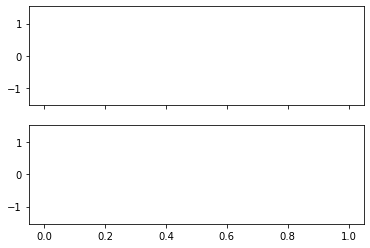

In [28]:
ani, fig = plot.create_animation_output_dir(problem.output_dir)
HTML(ani.to_html5_video())

## FV Convergence

In [29]:
matrix = np.array([[2, 1], [1, 2]])
initial_condition = x_functions.ComposedVector([x_functions.Sine(), x_functions.Cosine()])
time_final = 1.0
exact_solution = linear_system.ExactSolution(initial_condition, matrix)
exact_final_solution = x_functions.FrozenT(exact_solution, time_final)

problem = smooth_example.SmoothExample(matrix, initial_condition)
problem.parameters["time_final"] = time_final
problem.parameters["use_wave_propagation_method"] = True

problem.parameters["basis"]["basis_class"] = "finite_volume"

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["order"] = 1
problem.parameters["time_stepping"]["is_verbose"] = False

x_left = 0.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right

problem.parameters["fluctuation_solver"]["fluctuation_solver_class"] = "exact_linear"

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"

In [34]:
cfl = dg_utils.standard_cfls(1)
error_list = []
for num_elems in [20, 40]:
    problem.parameters["delta_t"] = dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems)
    problem.parameters["mesh"]["num_elems"] = num_elems
    final_solution = main.run(problem)
    error = math_utils.compute_error(final_solution, exact_final_solution)
    error_list.append(error)
order = utils.convergence_order(error_list)
print(order)
print(error_list)
if error_list[-1] >= math_utils.MACHINE_ERROR:
    assert order >= 1

1.0
[0.34176090722017843, 0.1983804354865396]


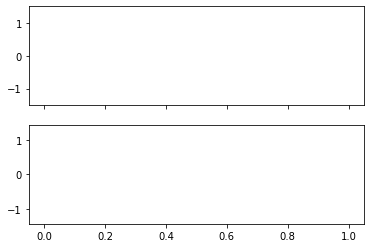

In [32]:
ani, fig = plot.create_animation_output_dir(problem.output_dir)
HTML(ani.to_html5_video())